In [1]:
import pandas as pd
import numpy as np
import string
from math import exp

In [2]:
products=pd.read_csv('amazon_baby_subset.csv')

In [3]:
important_words=pd.read_json('important_words.json')[0].tolist()

In [4]:
products=products.fillna({'review':''})

In [5]:
def translate(text):
    translator=str.maketrans({k:'' for k in string.punctuation})
    return text.translate(translator)

In [6]:
products['clean_review']=products.loc[:,'review'].apply(translate)

In [7]:
products.head()

,name,review,rating,sentiment,clean_review
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


In [8]:
for word in important_words:
    products[word] = products['clean_review'].apply(lambda s : s.split().count(word))

In [9]:
tr_idx=pd.read_json('module-10-assignment-train-idx.json')[0].tolist()

In [10]:
va_idx=pd.read_json('module-10-assignment-validation-idx.json')[0].tolist()

In [11]:
train_data=products.iloc[tr_idx]
valid_data=products.iloc[va_idx]

In [12]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.values
    label_sarray = dataframe[label]
    label_array = label_sarray.values
    return(feature_matrix, label_array)

In [13]:
matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
matrix_valid, sentiment_valid = get_numpy_data(valid_data, important_words, 'sentiment')

C:\Users\shuoyan001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

In [41]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors,feature)
        # Return the derivative
    return derivative

In [42]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

In [43]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, matrix_train[i:i+1,j])
print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [44]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions
gradient_mini_batch = feature_derivative(errors, matrix_train[i:i+B,j])
print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [45]:
len(train_data)

47780

In [60]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []

    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions = predict_probability(feature_matrix[i:i+batch_size,:],coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = sentiment[i:i+batch_size]==1

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative = feature_derivative(errors,feature_matrix[i:i+batch_size,j])
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
            coefficients[j] += (derivative*step_size)/batch_size
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [61]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


In [62]:
coef_st,likelihood_st=logistic_regression_SG(matrix_train,sentiment_train,np.zeros(194),5e-1,1,10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


In [63]:
coef_bt,likelihood_bt=logistic_regression_SG(matrix_train,sentiment_train,np.zeros(194),5e-1,len(matrix_train),200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

In [72]:
coef_bt10,likelihood_bt10=logistic_regression_SG(matrix_train,sentiment_train,np.zeros(194),1e-1,100,4788)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

No handles with labels found to put in legend.


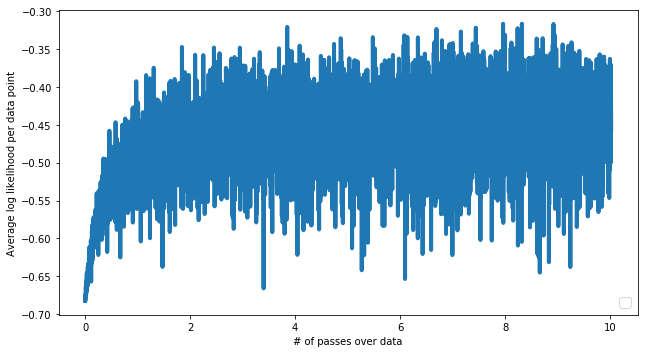

In [70]:
make_plot(likelihood_bt10,len(train_data),100)

No handles with labels found to put in legend.


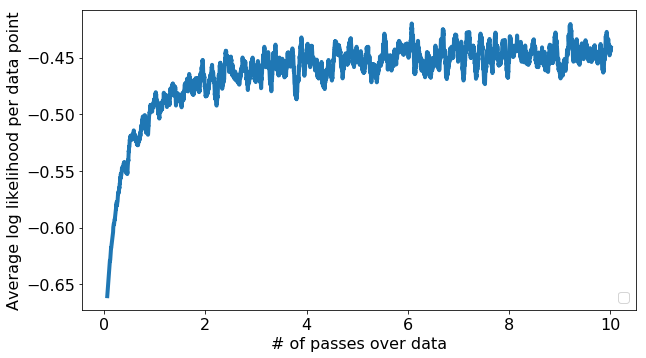

In [78]:
make_plot(likelihood_bt10,len(train_data),100,smoothing_window=30)

In [73]:
coef_bt100,likelihood_bt100=logistic_regression_SG(matrix_train,sentiment_train,np.zeros(194),1e-1,100,len(matrix_train)*2)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

No handles with labels found to put in legend.


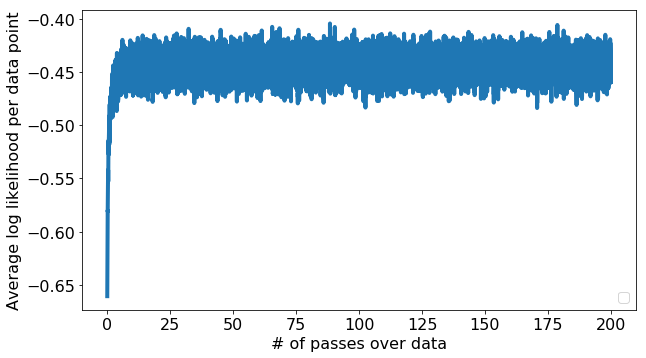

In [76]:
make_plot(likelihood_bt100,len(matrix_train),100,smoothing_window=30)

No handles with labels found to put in legend.


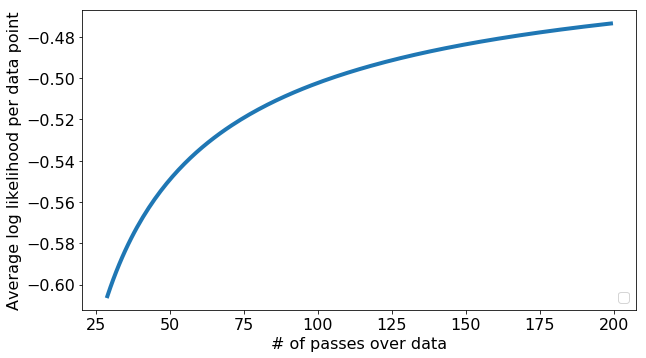

In [77]:
make_plot(likelihood_bt,len(matrix_train),len(matrix_train),smoothing_window=30)

In [80]:
coef_dif_step={}
likelihood_dif_step={}
for i in np.logspace(-4,2,num=7):
    coef_dif_step[i],likelihood_dif_step[i]=logistic_regression_SG(matrix_train,sentiment_train,np.zeros(194),i,100,4788)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

Iteration  100: Average log likelihood (of data points  [10000:10100]) = -0.60976663
Iteration  200: Average log likelihood (of data points  [20000:20100]) = -0.54566060
Iteration  300: Average log likelihood (of data points  [30000:30100]) = -0.48245740
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -0.46629313
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -0.47223389
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -0.52216798
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -0.52336683
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -0.46963453
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -0.47883783
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -0.46988191
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -0.46365531
Iteration 3000: Average log likelihood (of data points  [13800:13

Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -4.54798564
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -18.25204800
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -1.83420591
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -23.70968569
Iteration 4787: Average log likelihood (of data points  [01700:01800]) = -3.01257641


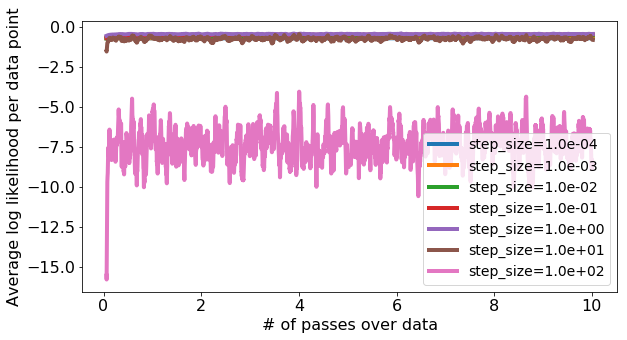

In [87]:
for i in np.logspace(-4,2,num=7):
    make_plot(likelihood_dif_step[i],len(matrix_train),100,smoothing_window=30,label='step_size=%.1e'%i)

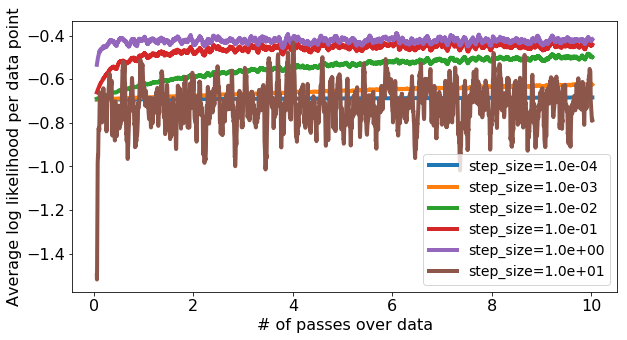

In [88]:
for i in np.logspace(-4,2,num=7)[0:6]:
        make_plot(likelihood_dif_step[i],len(matrix_train),100,smoothing_window=30,label='step_size=%.1e'%i)